## Supplementary material

This jupyter notebook accompanies the research article "Analytical solutions for the evaporation of pure cryogens in storage tanks" to provide software implementation of the developed analytical solutions. The notebook is organized in three subsections. In the first subsection, classes for storage tanks and cryogens are created and their attributes are listed. In the second subsection, the analytical solutions and auxiliary functions are defined for both equilibrium and non-equilibrium models. After the definitions, a storage tank and a cryogen are initialized as an example, and examples of implemented classes and solutions are provided. The last section describes the numerical methods required to implement the solutions for (i) direct calculation, (ii) thermophysical iteration and (iii) sequential calculation.

For further information please contact : 

Felipe Huerta, f.huerta-perez17@imperial.ac.uk, Velisa Vesovic, v.vesovic@imperial.ac.uk 

### Import required packages and libraries

In [1]:
# Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import copy # Copy constructor
%matplotlib inline 

# Classes definitions
To facilitate the implementation of the analtical solutions, two classes were defined.

## Storage tank class
The storage tank class contains information on the geometrical and thermal properties of a vertical cylindrical storage tank

In [2]:
class Tank:
    """ Class to be used as a container for the 
    evaporation of pure cryogens"""
    def __init__(self, d_i, d_o, V):
        """ Class constructor """
        # Compulsory parameters
        self.d_i = d_i # [m] Tank internal diameter 
        self.d_o = d_o # [m] Tank external diameter
        self.V = V     # [m^3] Tank volume
        self.A_T = np.pi*d_i**2/4 # [m^2] Area of the surface
        # perpendicular to the vertical axis
        self.l = V/self.A_T # [m] Tank height
        self.roof_BC = 'Neumann' # Roof Temperature boundary condition,
        # "Neumann" or "Robin"
        self.thermophysical_it =  False # Thermophysical iteration 
        # switch for the non-eq model
        pass
    
    def set_HeatTransProps(self, U_L, U_V, Q_b, Q_roof, T_air):
        """Set separately tank heat transfer properties
        Usage: set_HeatTransProps(self, U_L, U_V, Q_b, Q_roof, T_air)"""
        self.U_L = U_L # [W*m^-2*K^-1]Overall heat transfer coefficient
        # for the liquid phase stored in the tank
        self.U_V = U_V # [W*m^-2*K^-1] Overall heat transfer coefficient
        # for the vapour phase stored in the tank
        self.Q_b = Q_b # [W] Heat ingress through the bottom / W
        self.Q_roof = Q_roof # [W] Heat ingress through the roof
        self.T_air = T_air # [K] Temperature of the surrounding air /K
        pass
    
    def set_LF(self, LF): 
        """Update liquid filling and vapour length""" 
        self.LF = LF # [-] set tank liquid filling
        self.l_V = self.l * (1-LF) # [m] sets vapour length
        pass
    
    def set_advective_v(self):
        """Update advective velocity with respect to tank liquid filling"""
        # Area of the tank walls in contact with the liquid phase
        A_L = np.pi * self.d_o * self.l * self.LF
        # Initial wall heat ingress 
        Q_L0 = self.U_V * A_L * (self.T_air-self.cryogen.T_sat)
        # Initial evaporation rate mol/s
        BL_0 = (Q_L0 + self.Q_b)/((self.cryogen.h_V-self.cryogen.h_L))
        self.v_z = 4*BL_0/(self.cryogen.rho_V*np.pi*self.d_i**2)
        pass

## Cryogen class definition
The cryogen class contains the thermophysical properties of a pure cryogen.

In [3]:
class Cryogen:
    """ Class which contains a cryogen thermodynamic
    and thermophysical properties """
    def __init__(self, name, P, T_sat, rho_L, rho_V, h_L, h_V, k_V, cp_V):
        """Constructor"""
        self.name = name
        self.P = P # Pressure / Pa
        self.T_sat = T_sat # Saturation temperature / K
        self.rho_L = rho_L # Liquid Density / mol*m^-3
        self.rho_V = rho_V # Vapour density / mol*m^-3
        self.rho_V_sat = rho_V # Initialize vapour density at the interface
        self.h_L = h_L # Liquid enthalpy J/mol
        self.h_V = h_V # Vapour enthalpy J/mol
        self.k_V = k_V # Thermal conductivity of the vapour W/mK
        self.k_int = k_V # Thermal conductivity at the vapour-liquid interface
        self.cp_V = cp_V # Heat capacity at constant pressure / J/molK

# Analytical solutions and auxiliary functions

## Equilibrium model

We can build the solutions from a selected storage tank

In [4]:
def equilibrium_sols(tank):
    """Calculates coefficients C and D in the analytical solution
    
    Return values:    C, D, V_L0    """
    C = -4*tank.d_o/tank.d_i**2 * \
    (tank.T_air - tank.cryogen.T_sat) / \
    (tank.cryogen.rho_L*(tank.cryogen.h_V - tank.cryogen.h_L)) * \
    (tank.U_L - tank.U_V)
    
    D = -1 /(tank.cryogen.rho_L*(tank.cryogen.h_V - tank.cryogen.h_L)) * \
    ( 4*tank.d_o/tank.d_i**2 * (tank.T_air - tank.cryogen.T_sat) * \
    tank.U_V * tank.V + tank.Q_b )
    
    V_L0 = tank.V*tank.LF
    
    return C, D, V_L0

In [5]:
def V_L(t, C, D, V_L0):
    """Analytical solution for the liquid volume"""
    if (C != 0):
        V_L = D/C * ( np.exp(C*t)-1 ) + V_L0*np.exp(C*t)
    else:
        V_L = D*t + V_L0
    return V_L

# We can also define the BOG rate
def BOG(t, cryogen, C, D, V_L0):
    """BOG"""
    return (cryogen.rho_V - cryogen.rho_L) * ( C*V_L(t, C,D,V_L0) + D)

In [6]:
def tau_evap(C,D,V_L0):
    """tau_evap(C,D,V_L0) estimates the evaporation time"""
    if C != 0:
        tau_evap = -1/C * np.log (1 + V_L0 * C/D)
    else:
        tau_evap = - V_L0/D
    return tau_evap

## Initialize cryogens

In [7]:
# Cryogen thermophysical properties obtained from REFPROP 9.0

# Nitrogen

k_V = 7.1744e-3   #  W/(m2K)
k_V_roof = k_V # Assume k_V_roof = k_V 
rho_V = 162.65316 # mol/m^3
rho_L = 2.8793e4  # mol/m^3
cp_V = 31.4624    # J/molK
T_L = 77.2435     # /K
h_V = 2.2045e3    # J/kgK
h_L = -3.3132e3   # J/kgK
P = 100000        # Pa

nitrogen = Cryogen("nitrogen", P, T_L, rho_L, rho_V, h_L, h_V, k_V, cp_V)

# Methane
methane = Cryogen("methane", 116325, 113.2534, 2.6205e4, 128.1975, \
                 98.9155, 8.2684e3, 0.0117, 35.7950)

## Initialize large tank

In [8]:
# Input tank properties
Q_roof = 0 # W
d_i = 76.4 # m
d_o = 80   # m
LF = 0.97 
T_air = 293.15 # K
U_V = 0.0371 # W/m^2K
Q_b = 60000 # W, heat ingress from the bottom
V_tank = 165000 #m^3

# Initialize tank
large_tank = Tank(d_i, d_o, V_tank)
large_tank.set_HeatTransProps(U_V, U_V, Q_b, Q_roof, T_air)
large_tank.set_LF(LF)
large_tank.cryogen = methane
large_tank.set_advective_v()

In [9]:
# Build the analytical solutions
C, D, V_L0 = equilibrium_sols(large_tank)

## Non-equilibrium model functions and solutions

### Create the coefficients $\chi_{\pm,}, c_1$ and $c_2$

In [10]:
# PDE coefficients
def analytical_T_neq(tank):
    """ Calculates the parameters for the vapour temperature 
    profile & vapour to liquid heat transfer rate
    
    Return values:
    chi_minus, chi_plus, c_1, c_2
    """
    name_BC = tank.roof_BC
    cryo = tank.cryogen
    H = cryo.rho_V*cryo.cp_V*tank.v_z
    S = 4*tank.U_V*tank.d_o/tank.d_i**2
    E = S*tank.T_air
    # Temperature gradient at the tank roof, if defined
    try:
        gradT_roof = tank.Q_roof/(tank.k_V_roof*tank.A_T)
    except:
        gradT_roof = tank.Q_roof/(cryo.k_V*tank.A_T)            
    # Chi plus minus
    chi_plus = (H + np.sqrt(H**2+4*cryo.k_V*S))/(2*cryo.k_V)
    chi_minus = (H - np.sqrt(H**2+4*cryo.k_V*S))/(2*cryo.k_V)
        
    b_plus = np.exp(tank.l_V*chi_plus)
    b_minus = np.exp(tank.l_V*chi_minus)

    a_plus = chi_plus*b_plus
    a_minus = chi_minus*b_minus
    
    if(name_BC == "Neumann"):
        c_1 = (a_plus*(cryo.T_sat-tank.T_air) - gradT_roof)/(a_plus-a_minus)
        c_2 = (a_minus*(tank.T_air-cryo.T_sat) + gradT_roof)/(a_plus-a_minus)
    elif (name_BC == "Robin"):
        try:
            gamma = U_roof / k_V_roof
        except:
            gamma = tank.U_V / k_V_roof
        c_1 = (cryo.T_sat-tank.T_air)*(a_plus + gamma*b_plus)/ \
        ( (a_plus+gamma*b_plus)-(a_minus + gamma*b_minus))
        c_2 = (tank.T_air-cryo.T_sat)*(a_minus + gamma*b_minus) /\
        ((a_plus + gamma*b_plus) - (a_minus + gamma*b_minus))
    else:
        raise Exception("Unsupported BC, use Neumann or Robin")
    return chi_minus, chi_plus, c_1, c_2

### Vapour temperature

In [11]:
def T_V(z, c_1, c_2, chi_minus, chi_plus, T_air):
    """Outputs the vapour temperature profile. 
    z must be a length vector with 0 < z < l_V.
    The coefficients of the vapour T profile are also inputs"""
    TV = c_1*np.exp(z*chi_minus) + c_2 * np.exp(z*chi_plus) + T_air
    return TV

### Vapour to liquid heat transfer rate

In [12]:
def Q_VL(tank):
    """Calculates the vapour to liquid heat ingress"""
    chi_minus, chi_plus, c_1, c_2 = analytical_T_neq(tank)
    Q = np.pi * tank.d_i **2/4 * tank.cryogen.k_int * (c_1*chi_minus + c_2*chi_plus)
    return Q

### Average vapour temperature

In [13]:
def Tv_avg(tank):
    """Calculates the average vapour temperature
    for the non-equilibrium model"""
    chi_minus, chi_plus, c_1, c_2 = analytical_T_neq(tank)
    Tv_avg = tank.T_air + 1/tank.l_V * \
    (c_1/chi_minus * (np.exp(tank.l_V*chi_minus)-1) + \
     c_2/chi_plus * (np.exp(tank.l_V*chi_plus)-1))
    return Tv_avg

### Non-equilibrium coefficients

In [14]:
def analytical_neq(tank):
    """Calculates C_neq and D_neq coefficients"""
    C_neq = -4*tank.d_o/tank.d_i**2 * \
    (tank.T_air - tank.cryogen.T_sat) / \
    (tank.cryogen.rho_L * (tank.cryogen.h_V - tank.cryogen.h_L))* \
    tank.U_L

    D_neq = - (tank.Q_b + tank.Q_VL)/\
    (tank.cryogen.rho_L * (tank.cryogen.h_V - tank.cryogen.h_L))
    return C_neq, D_neq

In [15]:
def Tv_plot(tank):
    """Function to plot vapour temperature profile"""
    zspan = np.linspace(0,tank.l_V,100)
    chi_minus, chi_plus, c_1, c_2 = analytical_T_neq(tank)
    plt.plot(zspan, T_V(zspan, c_1=c_1, c_2=c_2, chi_minus=chi_minus, \
                        chi_plus = chi_plus, T_air = tank.T_air), 'r')
    plt.xlabel("Height")
    plt.ylabel("Vapour Temperature")

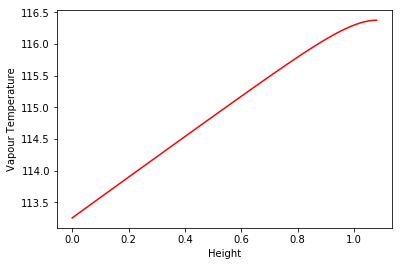

In [16]:
# Example of usage of Tv_plot function
Tv_plot(large_tank)

## Initialize medium-size storage tank

In [17]:
# Tank properties
Q_roof = 0 # [W]
d_i = 2.8540 # [m]
d_o = 3.1480 # [m]
V_tank = 80.36 # [m^3]
LF = 0.97 
T_air = 288.15 # [K]
U_V = 0.0110 # W/[m^2*K]
Q_b = 17.335 # [W], heat ingress from the bottom

mid_tank = Tank(d_i, d_o, V_tank)
mid_tank.set_HeatTransProps(U_V, U_V, Q_b, Q_roof, T_air)
mid_tank.set_LF(LF)
mid_tank.cryogen = nitrogen
mid_tank.set_advective_v()
mid_tank.Q_VL = 0
mid_tank.roof_BC = "Robin"

# Numerical Methods

## Direct calculation

In [18]:
def direct(tank, timespan):
    C_neq, D_neq = analytical_neq(tank)
    my_tank = copy.deepcopy(tank)
    V_L_direct = V_L(timespan, C=C_neq, D=D_neq, V_L0 = my_tank.V*my_tank.LF)
    Q_VL_direct = np.zeros(len(V_L_direct))
    for i in range(0,len(V_L_direct),1):
        my_tank.set_LF(V_L_direct[i]/my_tank.V)        
        # Get the temperature profile
        chi_minus, chi_plus, c_1r, c_2r = analytical_T_neq(my_tank)
        # Update Q_VL
        my_tank.Q_VL = Q_VL(my_tank)
        Q_VL_direct[i] = my_tank.Q_VL
        my_tank.set_advective_v()
        # Update advective velocity

    return V_L_direct, Q_VL_direct

## Thermophysical iteration

This iteration updates the thermophysical properties of the vapour calculated at each timestep at the average temperature. In the original, publication the REFPROP 9.0 library was used to obtain the thermophysical properties of methane and nitrogen at different temperatures and pressures. In this Notebook, we provide polynomials to evaluate $c_p, k_V$ and $\rho_V$ for methane and nitrogen. For methane, the calculation is performed at the operating pressure of the large tank, while for nitrogen the operating pressure of the small and medium sized tanks is used.

In [19]:
def T_vec(T):
    """ Utility to calculate polynomials of 6th degree"""
    return np.array([T**6, T**5, T**4, T**3, T**2, T, 1])

def k_V(T, cryogen_name):
    """Vapour thermal conductivity in W/[m*K]"""
    if cryogen_name == "nitrogen":
        coef = np.array([1.2891e-17,- 1.6853e-14, 8.9835e-12,\
                         - 2.4280e-9, 2.7918e-7, 8.4564e-5, - 1.8214e-4])
    else:
        coef = np.array([1.05745348829032e-16,-1.66976160737431e-13,\
                         1.06067666935673e-10,-3.42308423973392e-08,\
                         5.92114833456723e-06, -0.000405925906877382,\
                         0.0169054855927478])
    k_V = np.dot(T_vec(T),coef)
    return k_V
    
def rho_V(T, cryogen_name):
    """Vapour density in mol/[m^3]"""
    if cryogen_name == "nitrogen":
        # P = 100 kPa
        coef = np.array([4.023e-12, - 5.3256e-9, 2.9169e-6,\
                         - 8.5257e-4, + 0.1429, - 13.5159, 658.0484]) 
    else:
        coef = np.array([2.18499589355086e-12, -3.14564341280599e-09,\
                         1.89240405227852e-06, -0.000614011250006166,\
                         0.115248233542307,\
                         -12.3574905769077,681.411457371657])
    rho_V = np.dot(T_vec(T),coef)
    return rho_V

def cp_V(T, cryogen_name):
    """ Vapour specific heat capacity in J/[mol*K] """
    if cryogen_name == "nitrogen":
        coef = np.array([4.8391e-13, - 6.2028e-10,\
                         3.2526e-7, - 8.9351e-5,\
                         0.0136, - 1.0915, 65.8080])
    else:
        coef = np.array([8.79997426965283e-13, -1.21803356592957e-09\
                         ,6.93498674769963e-07, \
                         -0.000207819771422151,\
                         0.0347286371956103,\
                         -3.08698360179143,\
                         148.487772497283])
    cp = np.dot(T_vec(T),coef)
    return cp

def thermophysprops(T,cryogen_name):
    return k_V(T,cryogen_name), rho_V(T, cryogen_name), cp_V(T, cryogen_name)

In [20]:
def thermophysical_iteration(tank):
    """Update k_V, rho_V and cp_V 
    for a given liquid filling"""
    # Initialise old vapour temperature
    T_old = 0
    T_new = Tv_avg(tank)
    while abs(T_old-T_new) > 1e-2:
        T_old = T_new
        # Unpack thermophysical properties
        k, rho, cp = thermophysprops(T_old, tank.cryogen.name)
        # Update thermophysical properties
        tank.cryogen.k_V = k
        tank.cryogen.rho_V = rho
        tank.cryogen.cp_V = cp
        T_new = Tv_avg(tank)

## Sequential numerical procedure

To improve the performance of the analytical solutions

In [21]:
def sequential_proc(tank, delta_t = 3600*24*7):
    """ Default timestep delta_t is a week
    delta_t must be in seconds
    
    Returns
    
    timespan: np.array, timestamps
    V_L_analytical: np.array, liquid volume
    Q_VL_analytical: np.array, vapour to liquid heat ingress
    T_V_analytical: np.array of i*j dimensions.
    T_V_analytical[i,j] corresponds to the
    temperature profile of the j node in the vapour
    at timespan[i], while     T_V_analytical[i,:] 
    is the whole vapour temperature profile at timespan[i]
    """
    # Initialize Q_VL for the tank
    tank.set_advective_v()
    tank.Q_VL = Q_VL(tank)
    
    # Obtain C and D
    C_neq, D_neq = analytical_neq(tank)

    # Estimate evaporation time
    tau_neq = tau_evap(C_neq,D_neq,tank.V*tank.LF)
    
    # get n_timesteps approximating to 
    # the highest nearest integer
    n_t = int(np.floor(tau_neq/(delta_t))+1) 
    timespan = np.linspace(0,tau_neq,n_t)

    # Initialize V_L and Q_VL
    V_L_analytical = np.zeros(n_t)
    Q_VL_analytical = np.zeros(n_t)
    
    V_L_analytical[0] = tank.V*tank.LF
    Q_VL_analytical[0] = tank.Q_VL
    
    LF = copy.deepcopy(tank.LF)
    my_tank = copy.deepcopy(tank)

    # Initialize vapour temperature
    n_z = 100 # Number of nodes in the vapour domain
    T_V_analytical = np.zeros([n_t, n_z])
    chi_minus, chi_plus, c_1, c_2 = analytical_T_neq(my_tank)
    z = np.linspace(0,my_tank.l_V,n_z)
    T_V_analytical[0,:] = T_V(z, c_1, c_2, chi_minus, chi_plus, T_air)

    
    for i in range(1, n_t,1):
        # Get V_L at t_0 + delta_t
        V_L_analytical[i] = V_L(delta_t, C=C_neq, D=D_neq,\
                                V_L0 = my_tank.V*my_tank.LF)
        # Update the liquid filling
        my_tank.set_LF(V_L_analytical[i]/my_tank.V)
        my_tank.set_advective_v()
        # If activated, update thermophysical properties
        if tank.thermophysical_it == True:
            thermophysical_iteration(my_tank)
        # Get the temperature profile for each time step
        chi_minus, chi_plus, c_1, c_2 = analytical_T_neq(my_tank)
        z = np.linspace(0,my_tank.l_V,n_z)
        T_V_analytical[i,:] = T_V(z, c_1, c_2, chi_minus, chi_plus, T_air)
        # Update Q_VL
        my_tank.Q_VL = Q_VL(my_tank)
        Q_VL_analytical[i] = my_tank.Q_VL                
        # Update C_neq, D_neq
        C_neq, D_neq = analytical_neq(my_tank)
    return timespan, V_L_analytical, Q_VL_analytical, T_V_analytical

### Usage example

In [22]:
# We can set on or of the update of thermophysical properties

# Set Q_VL at the initial liquid filling
mid_tank.Q_VL = Q_VL(mid_tank)
C_neq, D_neq = analytical_neq(mid_tank)

# Thermophysical iteration and sequential procedure
mid_tank.thermophysical_it = True
timespan, V_L_analytical, Q_VL_analytical, T_V_analytical = \
sequential_proc(mid_tank, delta_t = 3600*24*7)

# Sequential procedure only
mid_tank.thermophysical_it = False
timespan, V_L_analytical_s, Q_VL_analytical_s, T_V_analytical_s = \
sequential_proc(mid_tank, delta_t = 3600*24*7)

# Direct calculation
V_L_direct, Q_VL_direct = direct(mid_tank, timespan)